# Demo of scikit-learn models

In [1]:
import pandas as pd
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

## Synthetic control

In [4]:
from causal_impact.simulate_data import generate_synthetic_control_data

treatment_time = 70
df, weightings_true = generate_synthetic_control_data(treatment_time=treatment_time)

# SPLIT INTO OBSERVED PRE-TREATMENT DATA
data = (df[df.index < treatment_time]
        .loc[:,["a", "b", "c", "d", "e", "f", "g", "actual"]])
# SPLIT INTO OBSERVED POST-TREATMENT DATA
predict_data = (df[df.index >= treatment_time]
                .loc[:,["a", "b", "c", "d", "e", "f", "g", "actual"]])

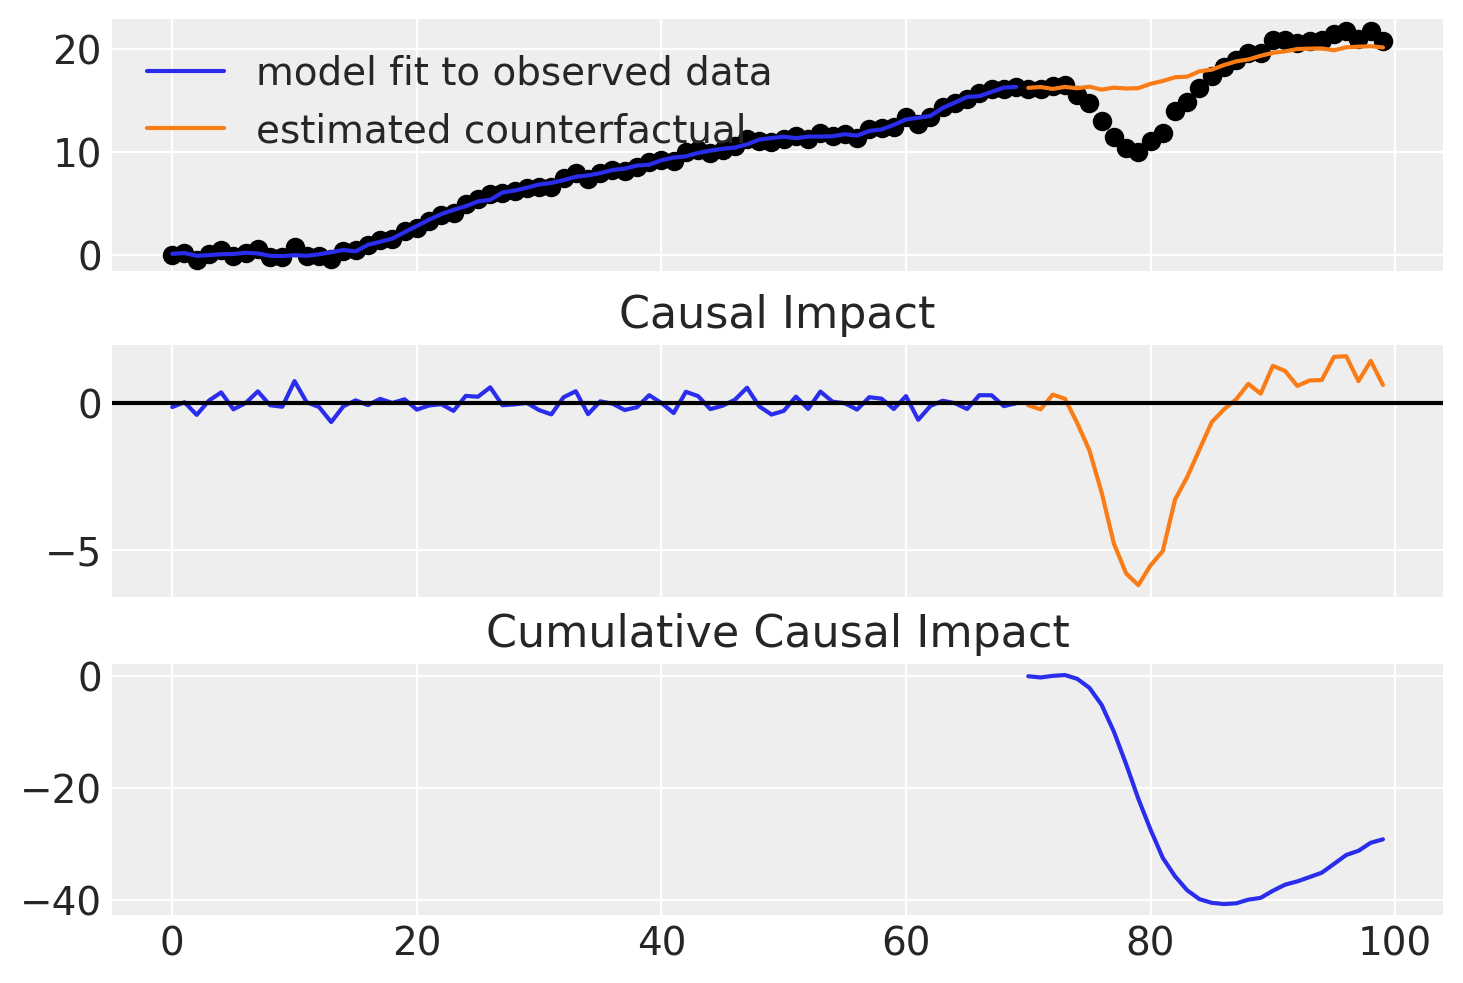

In [5]:
from causal_impact.skl import SyntheticControl
from sklearn import linear_model

model = linear_model.LinearRegression()
thing = SyntheticControl(data, 
                         predict_data, 
                         target_col="actual",
                         controls=["a", "b", "c", "d", "e", "f", "g"],
                         prediction_model=model)

thing.plot()

## Interrupted time series

In [6]:
df = pd.read_csv("../causal_impact/data/its_simple.csv")
df.set_index("date", inplace=True)
treatment_time = "2017-01-01"

# SPLIT INTO OBSERVED PRE-TREATMENT DATA
data = (df[df.index < treatment_time]
        .loc[:,["intercept", "linear_trend", "timeseries"]])

# SPLIT INTO OBSERVED POST-TREATMENT DATA
predict_data = (df[df.index >= treatment_time]
                .loc[:,["intercept", "linear_trend", "timeseries"]])

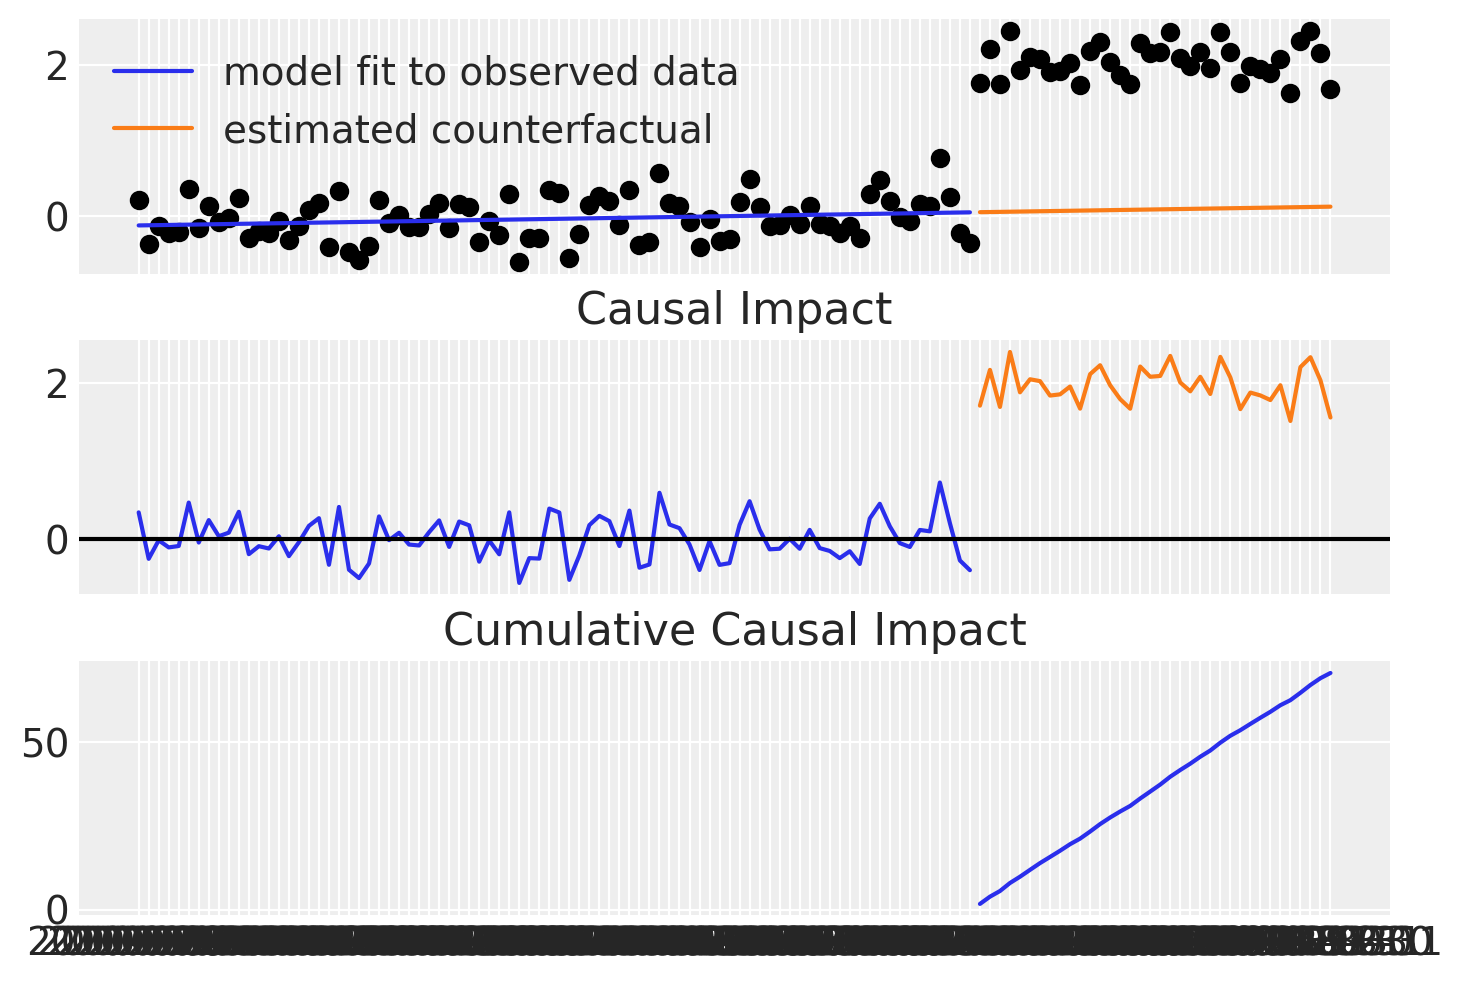

In [7]:
from causal_impact.skl import InterruptedTimeSeries
from sklearn import linear_model

model = linear_model.LinearRegression()
thing = InterruptedTimeSeries(data, predict_data, prediction_model=model)

thing.plot()

## Difference in Differences

In [8]:
data = pd.read_csv("../causal_impact/data/did.csv")

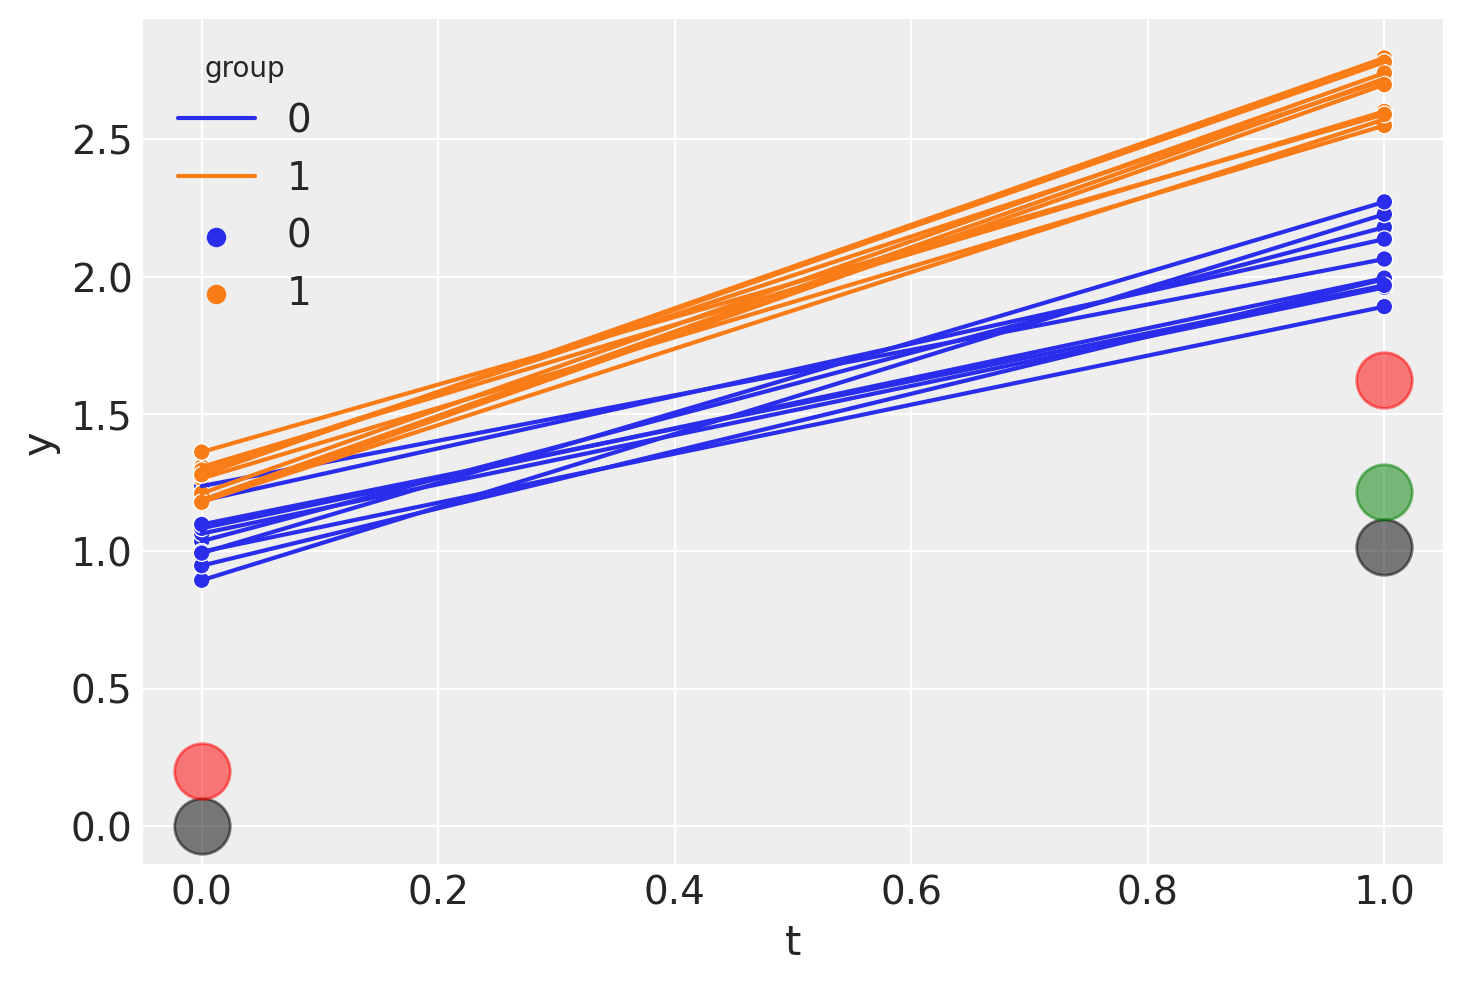

In [9]:
from causal_impact.skl import DifferenceInDifferences
from sklearn import linear_model

model = linear_model.LinearRegression()
thing = DifferenceInDifferences(data, 
                                formula = 'y ~ 1 + group + t + treated:group',
                                prediction_model=model)
thing.plot()